## Importing the relevant libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, itertools, random
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D, RandomRotation, RandomFlip, RandomZoom, RandomContrast
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetB0
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

## Loading the dataset

In [8]:
base_dir = r"D:/Internship_Tasks/Maharshi_Animal-_and_Human_Detection_Model/animal_dataset/animals/animals"
categories = os.listdir(base_dir)
num_classes = len(categories)
print(f"Total Classes: {num_classes}")

Total Classes: 90


In [9]:
image_paths, labels = [], []

for category in tqdm(os.listdir(base_dir)):
    for img_filepath in os.listdir(os.path.join(base_dir,category)):
        image_path = os.path.join(base_dir,category,img_filepath)
        image_paths.append(image_path)
        labels.append(category)

len(image_paths), len(labels)

  0%|          | 0/90 [00:00<?, ?it/s]

(5400, 5400)

In [10]:
df = pd.DataFrame({'image_filepath': image_paths, 'label': labels})
df.head()

,image_filepath,label
0,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope
1,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope
2,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope
3,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope
4,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope


## Data Exploration

In [11]:
df.shape

(5400, 2)

In [12]:
encoder = LabelEncoder()
df['encoded_label'] = encoder.fit_transform(df['label'])

In [13]:
df.head()

,image_filepath,label,encoded_label
0,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope,0
1,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope,0
2,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope,0
3,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope,0
4,D:/Internship_Tasks/Maharshi_Animal-_and_Human...,antelope,0


In [14]:
# Creating label index mapping
label_idx_mapping = dict()

for idx, label in enumerate(encoder.classes_):
    label_idx_mapping[label] = idx

label_idx_mapping

{'antelope': 0,
 'badger': 1,
 'bat': 2,
 'bear': 3,
 'bee': 4,
 'beetle': 5,
 'bison': 6,
 'boar': 7,
 'butterfly': 8,
 'cat': 9,
 'caterpillar': 10,
 'chimpanzee': 11,
 'cockroach': 12,
 'cow': 13,
 'coyote': 14,
 'crab': 15,
 'crow': 16,
 'deer': 17,
 'dog': 18,
 'dolphin': 19,
 'donkey': 20,
 'dragonfly': 21,
 'duck': 22,
 'eagle': 23,
 'elephant': 24,
 'flamingo': 25,
 'fly': 26,
 'fox': 27,
 'goat': 28,
 'goldfish': 29,
 'goose': 30,
 'gorilla': 31,
 'grasshopper': 32,
 'hamster': 33,
 'hare': 34,
 'hedgehog': 35,
 'hippopotamus': 36,
 'hornbill': 37,
 'horse': 38,
 'hummingbird': 39,
 'hyena': 40,
 'jellyfish': 41,
 'kangaroo': 42,
 'koala': 43,
 'ladybugs': 44,
 'leopard': 45,
 'lion': 46,
 'lizard': 47,
 'lobster': 48,
 'mosquito': 49,
 'moth': 50,
 'mouse': 51,
 'octopus': 52,
 'okapi': 53,
 'orangutan': 54,
 'otter': 55,
 'owl': 56,
 'ox': 57,
 'oyster': 58,
 'panda': 59,
 'parrot': 60,
 'pelecaniformes': 61,
 'penguin': 62,
 'pig': 63,
 'pigeon': 64,
 'porcupine': 65,
 'pos

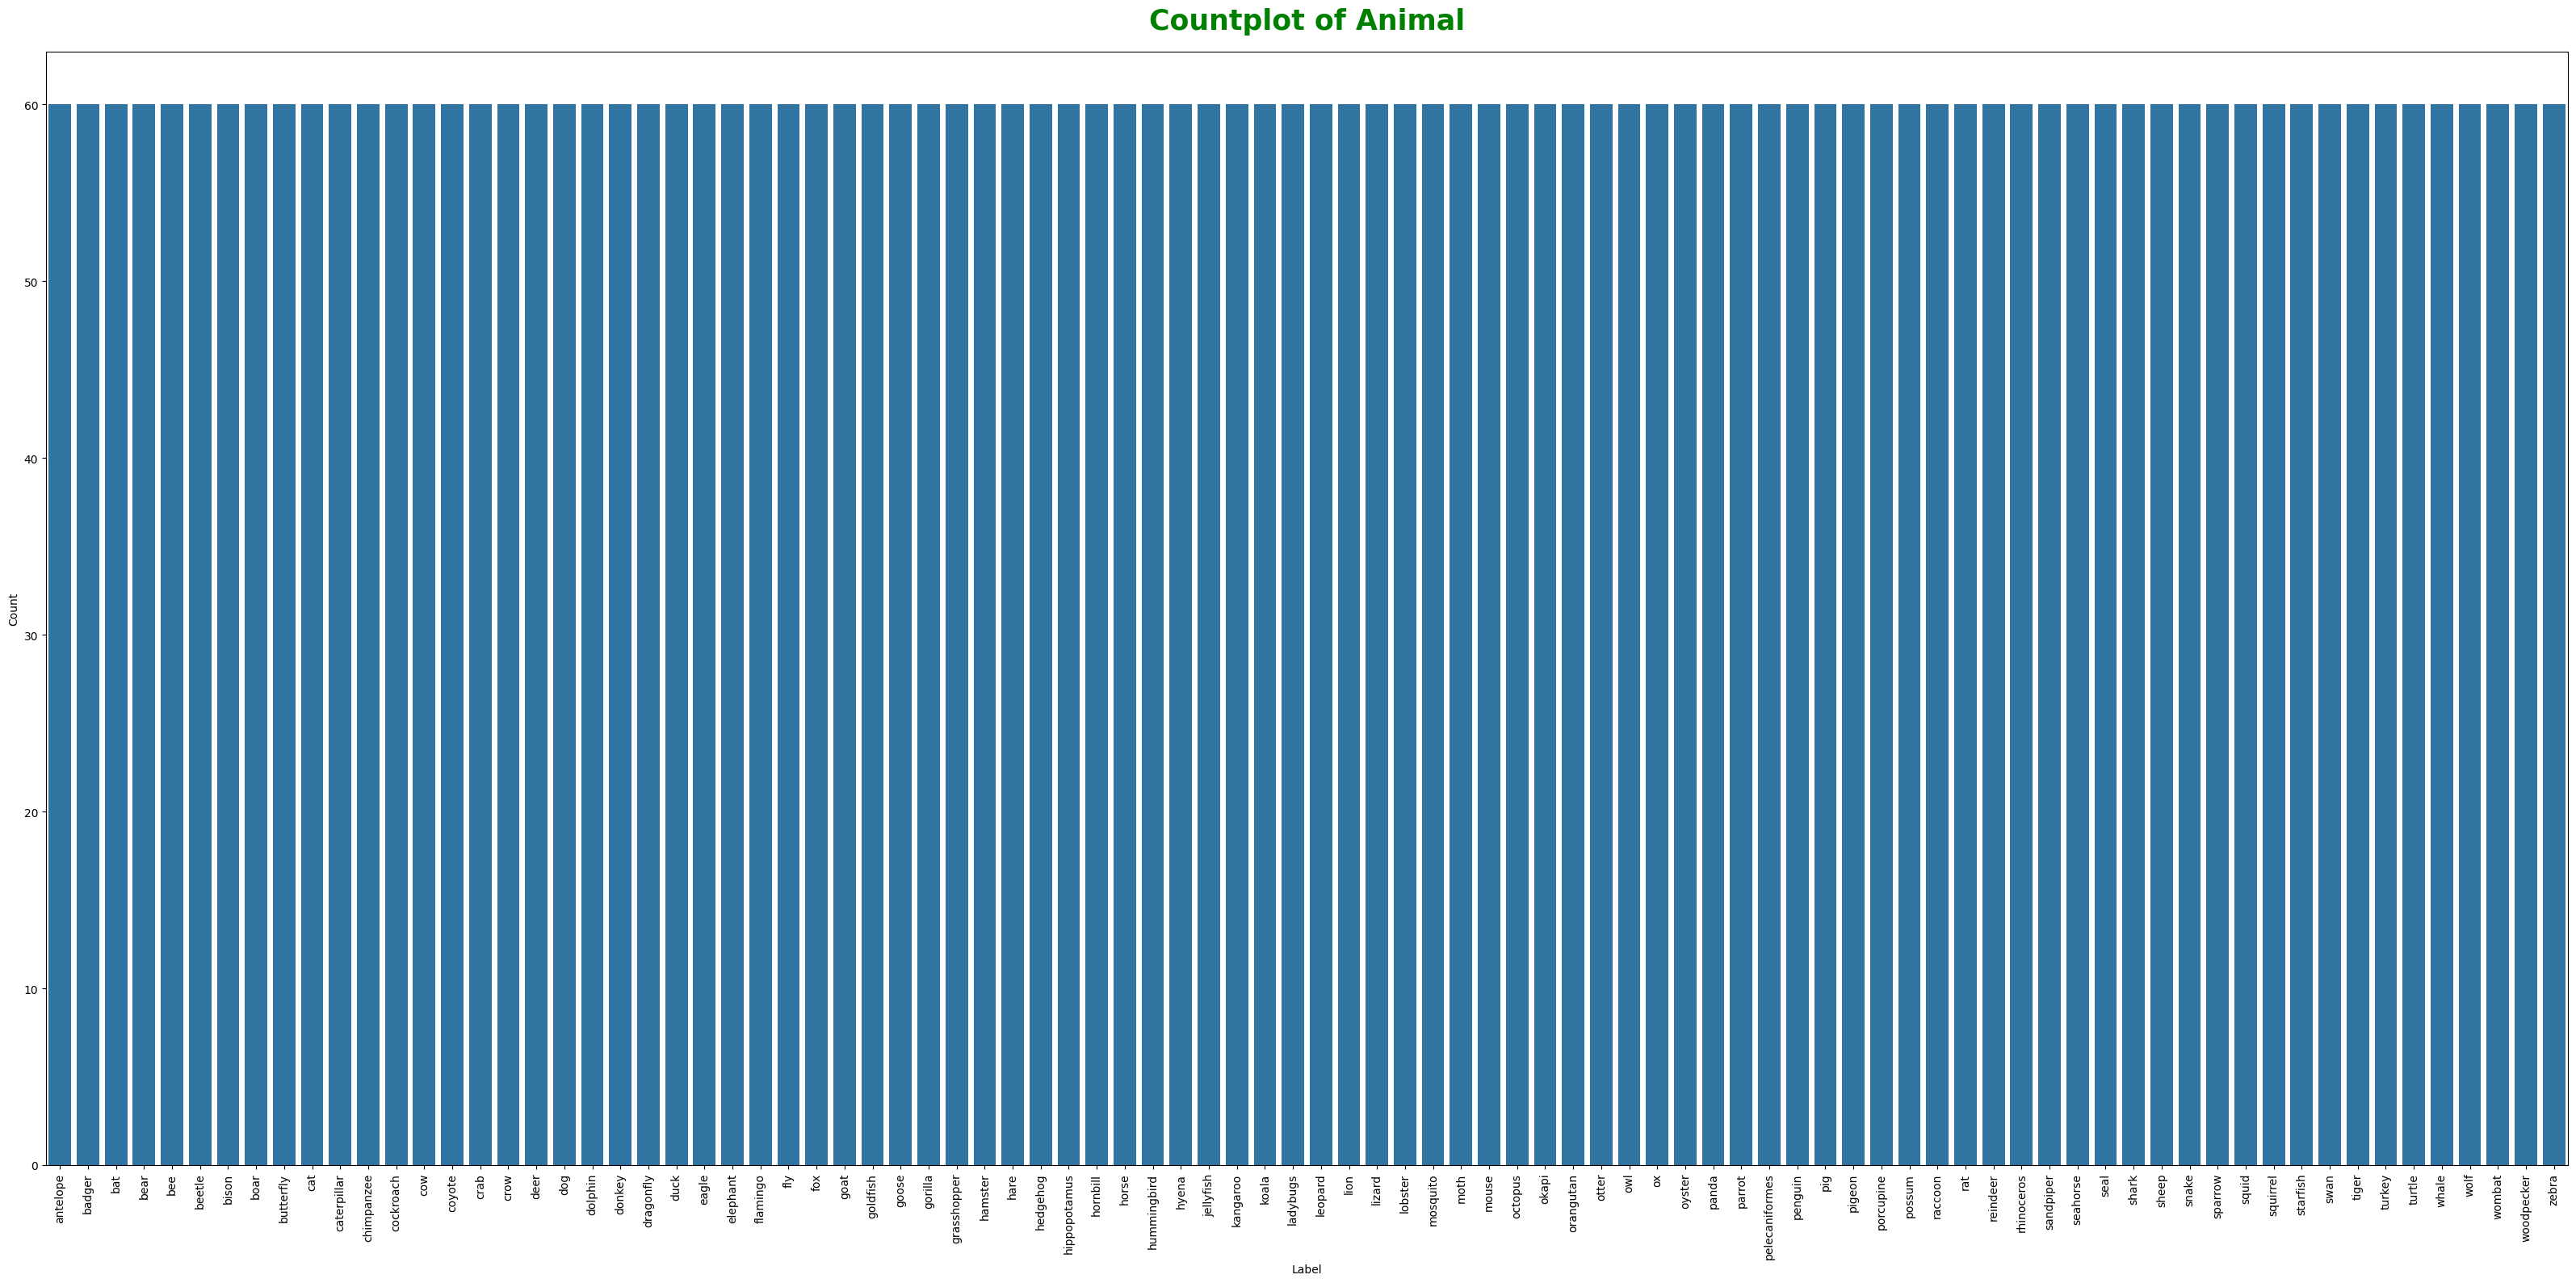

In [15]:
plt.figure(figsize=(32,16))
sns.countplot(data=df,x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Countplot of Animal',fontsize=25,pad=20,color='green',fontweight='bold')
plt.tight_layout()
plt.show();

All classes are equally balanced so there won't be imbalanced class problem.

## Performing train-validation-test split

In [16]:
train_df, temp_df = train_test_split(df,train_size=0.7,stratify=df['label'],random_state=101)
val_df, test_df = train_test_split(temp_df,train_size=0.7,stratify=temp_df['label'],random_state=101)

In [17]:
train_df.shape, val_df.shape, test_df.shape

((3779, 3), (1134, 3), (487, 3))

## Creating Image Data Generator objects for train-val-test

In [18]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
generator

In [19]:
train_data_generator = generator.flow_from_dataframe(
    train_df,
    x_col='image_filepath',
    y_col='label',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE
)

Found 3779 validated image filenames belonging to 90 classes.


In [20]:
val_data_generator = generator.flow_from_dataframe(
    val_df,
    x_col='image_filepath',
    y_col='label',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE
)

Found 1134 validated image filenames belonging to 90 classes.


In [21]:
test_data_generator = generator.flow_from_dataframe(
    test_df,
    x_col='image_filepath',
    y_col='label',
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE
)

Found 487 validated image filenames belonging to 90 classes.


## Defining the model architecture

In [22]:
n_classes = len(train_data_generator.class_indices)
n_classes

90

In [23]:
# Build EfficientNetB0 model
efficient_net_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='max'
)

16705208/16705208 [==============================] - 3s 0us/step


In [24]:
# Freeze the layers of the pretrained model
for layer in efficient_net_model.layers:
    layer.trainable = False

In [25]:
# Data Augmentation layer
augment_layer = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
],name='augmentation_layer')

In [26]:
inputs = Input(shape=(224,224,3))
x = augment_layer(inputs)
x = efficient_net_model(x, training=False)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(units=n_classes,activation='softmax')(x)

model = Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequen  (None, 224, 224, 3)       0         
 tial)                                                           
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                             

In [27]:
plot_model(model,to_file='model.png',dpi=200,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Model Training - Transfer Learning

In [28]:
# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=5e-4),
             metrics=['accuracy'])

In [31]:
!pip install wandb -q


In [48]:
import wandb
import wandb.keras
from wandb.keras import WandbCallback

# Start wandb run
wandb.init(
    project="animal-image-classifier",
    config={
        "epochs": 1,
        "batch_size": 32,
        "learning_rate": 0.01,
        "architecture": "keras_model",

        "optimizer": "adam",
        "loss_function": "categorical_crossentropy"
    }
)
wandb_callback = WandbCallback(
    training_data=train_data_generator,  # REQUIRED for gradient logging
    log_weights=True,
    log_gradients=True,
    save_model=True
)

In [49]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True, start_from_epoch=5),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=2, verbose=1),
    TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True),
    ModelCheckpoint(filepath='animal_image_classifier.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1),
    wandb_callback
]



In [50]:
model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=wandb.config.epochs,
    callbacks=callbacks,
    steps_per_epoch=len(train_data_generator),
    validation_steps=len(val_data_generator),
    verbose=1
)


119/119 [==============================] - ETA: 0s - loss: 2.1177 - accuracy: 0.5253
Epoch 1: val_accuracy improved from -inf to 0.75838, saving model to animal_image_classifier.keras


ValueError: The following argument(s) are not supported with the native Keras format: ['options']

In [51]:
wandb.finish()


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


## Visualizing model performance

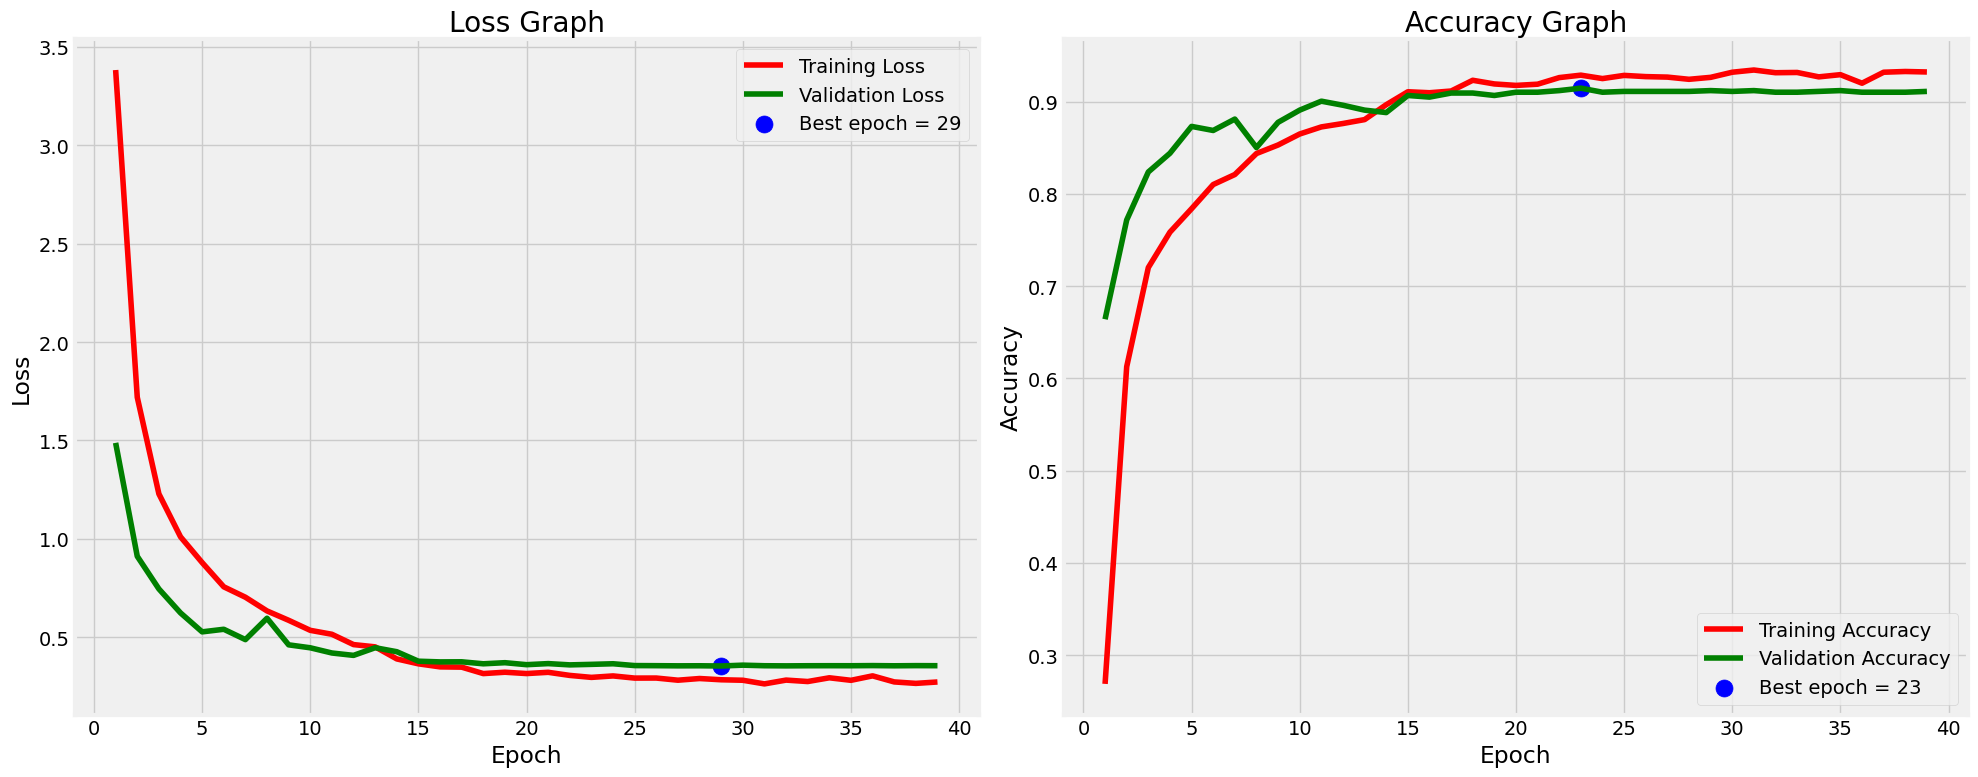

In [ ]:
# Extract training details from r.history
train_acc = r.history['accuracy']
train_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']

# Identify best epoch for loss and accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Create epoch index list and labels
epochs = list(range(1, len(train_acc) + 1))
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

In [ ]:
saved_model = model

## Fine-tuning the pretrained model

In [ ]:
# Unfreeze all layers first
for layer in efficient_net_model.layers:
    layer.trainable = True

# Freeze only the BatchNormalization layers
for layer in efficient_net_model.layers[-30:]:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False

In [ ]:
for layer in efficient_net_model.layers:
    if isinstance(layer, BatchNormalization):
        print(f"{layer.name} — trainable: {layer.trainable}")

stem_bn — trainable: True
block1a_bn — trainable: True
block1a_project_bn — trainable: True
block2a_expand_bn — trainable: True
block2a_bn — trainable: True
block2a_project_bn — trainable: True
block2b_expand_bn — trainable: True
block2b_bn — trainable: True
block2b_project_bn — trainable: True
block3a_expand_bn — trainable: True
block3a_bn — trainable: True
block3a_project_bn — trainable: True
block3b_expand_bn — trainable: True
block3b_bn — trainable: True
block3b_project_bn — trainable: True
block4a_expand_bn — trainable: True
block4a_bn — trainable: True
block4a_project_bn — trainable: True
block4b_expand_bn — trainable: True
block4b_bn — trainable: True
block4b_project_bn — trainable: True
block4c_expand_bn — trainable: True
block4c_bn — trainable: True
block4c_project_bn — trainable: True
block5a_expand_bn — trainable: True
block5a_bn — trainable: True
block5a_project_bn — trainable: True
block5b_expand_bn — trainable: True
block5b_bn — trainable: True
block5b_project_bn — traina

## Model Training - Fine Tuning

In [ ]:
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-5, # Lower learning rate is recommended for fine-tuning
    first_decay_steps=10,
    t_mul=2.0,
    m_mul=0.9,
    alpha=1e-6
)

model.compile(loss=CategoricalCrossentropy(label_smoothing=0.1),
             optimizer=Adam(learning_rate=lr_schedule),
             metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_layer (Sequential)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          23,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,401,661 (16.79 MB)

 Trainable params: 4,348,630 (16.59 MB)

 Non-trainable params: 53,031 (207.16 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss',mode='min',patience=5,verbose=1,restore_best_weights=True,start_from_epoch=5),
    TensorBoard(log_dir='./',histogram_freq=1,write_graph=True,update_freq='epoch',embeddings_freq=1),
    ModelCheckpoint(filepath='fine_tuned_animal_classifier.keras',monitor='val_accuracy',mode='max',save_best_only=True,verbose=1,save_freq='epoch')
]

r_fine = model.fit(
    train_data_generator,
    validation_data=val_data_generator,
    epochs=50,
    callbacks=callbacks,
    steps_per_epoch=len(train_data_generator),
    validation_steps=len(val_data_generator),
    verbose=1
)

Epoch 1/50


E0000 00:00:1749251751.045180      18 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7734 - loss: 1.7596
Epoch 1: val_accuracy improved from -inf to 0.86684, saving model to fine_tuned_animal_classifier.keras
119/119 ━━━━━━━━━━━━━━━━━━━━ 100s 392ms/step - accuracy: 0.7734 - loss: 1.7596 - val_accuracy: 0.8668 - val_loss: 1.5789
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7948 - loss: 1.6940
Epoch 2: val_accuracy did not improve from 0.86684
119/119 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.7947 - loss: 1.6942 - val_accuracy: 0.8148 - val_loss: 1.6741
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8004 - loss: 1.6601
Epoch 3: val_accuracy did not improve from 0.86684
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 340ms/step - accuracy: 0.8003 - loss: 1.6604 - val_accuracy: 0.7919 - val_loss: 1.7213
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8001 - loss: 1.6782
Epoch 4: val_accuracy did not improve from 0.86684
119/119 ━━━━━━━━━━━━━━━━━━━━ 40s 338ms/st

## Visualizing fine-tuned model performance

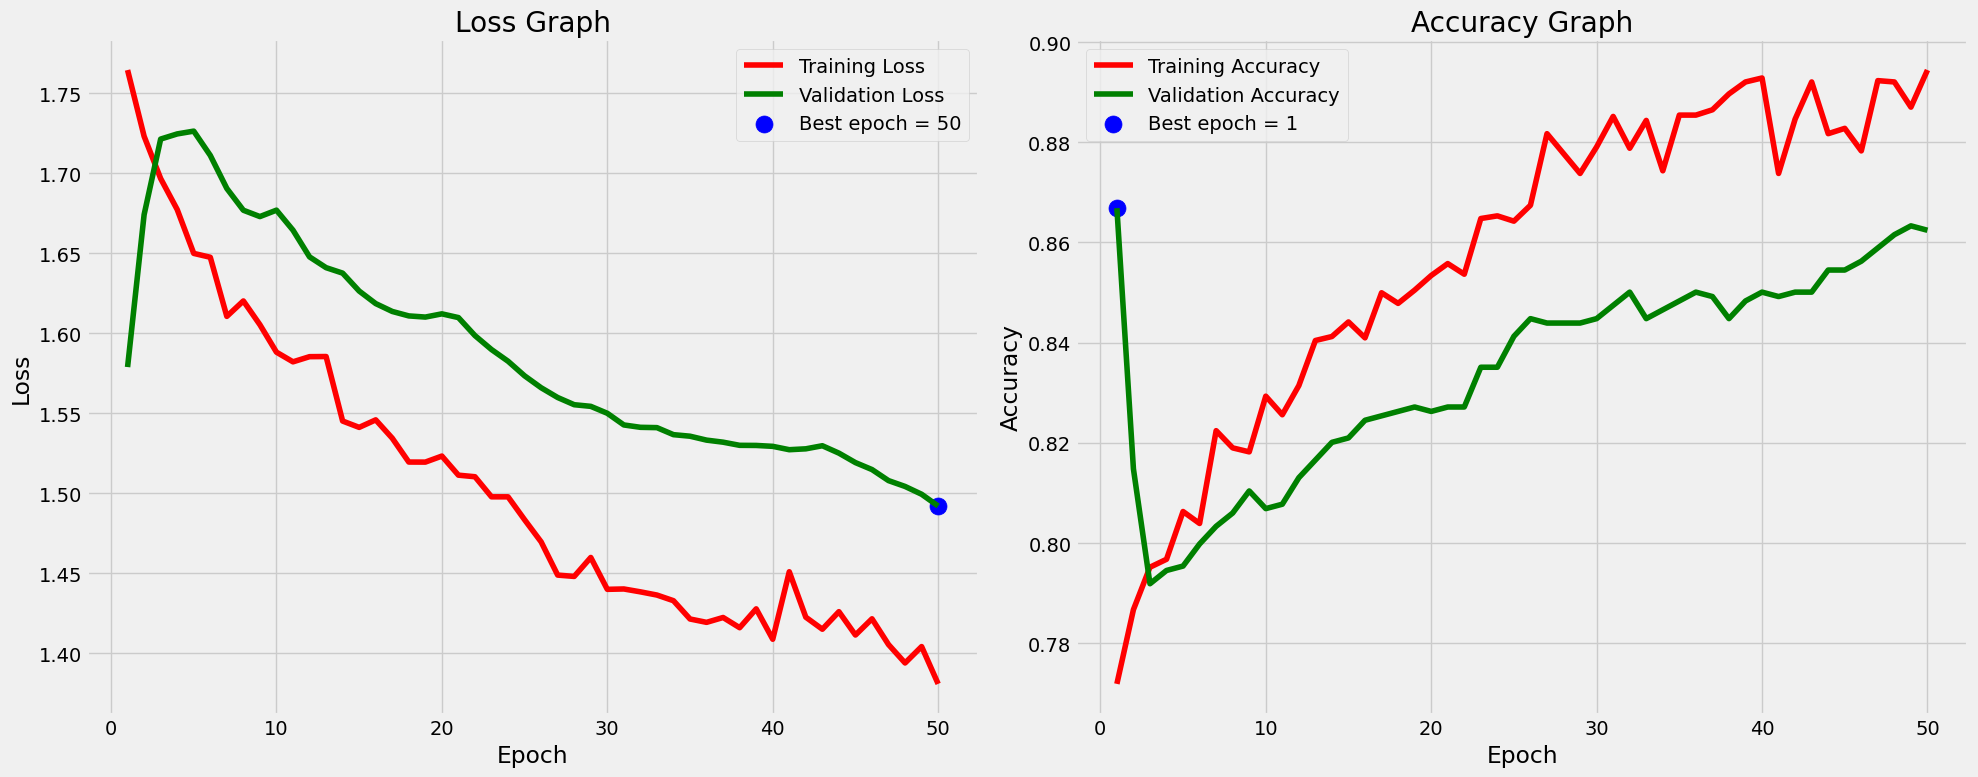

In [ ]:
# Extract training details from r.history
train_acc = r_fine.history['accuracy']
train_loss = r_fine.history['loss']
val_acc = r_fine.history['val_accuracy']
val_loss = r_fine.history['val_loss']

# Identify best epoch for loss and accuracy
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

# Create epoch index list and labels
epochs = list(range(1, len(train_acc) + 1))
loss_label = f'Best epoch = {index_loss + 1}'
acc_label = f'Best epoch = {index_acc + 1}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

## Model Evaluation

In [ ]:
best_model = load_model('animal_image_classifier.keras')
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ augmentation_layer (Sequential)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 90)                  │          23,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,104,819 (19.47 MB)

 Trainable params: 351,578 (1.34 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

 Optimizer params: 703,158 (2.68 MB)

In [ ]:
loss, acc = best_model.evaluate(test_data_generator)
print(f"Test Loss: {loss:.3f}")
print(f"Test Accuracy: {acc:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 381ms/step - accuracy: 0.9242 - loss: 0.2464
Test Loss: 0.238
Test Accuracy: 0.93


F1 Score (Macro): 0.926
Confusion Matrix:
[[6 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]
Classification Report:
                precision    recall  f1-score   support

      antelope       0.86      1.00      0.92         6
        badger       1.00      1.00      1.00         5
           bat       1.00      1.00      1.00         5
          bear       1.00      1.00      1.00         5
           bee       1.00      0.83      0.91         6
        beetle       0.86      1.00      0.92         6
         bison       1.00      1.00      1.00         5
          boar       1.00      1.00      1.00         6
     butterfly       1.00      1.00      1.00         6
           cat       1.00      1.00      1.00         6
   caterpillar       1.00      0.83      0.91         6
    chimpanzee       0.86      1.00      0.92         6
     cockroach       1.00      1.00      1.00         6
           cow       1.00     

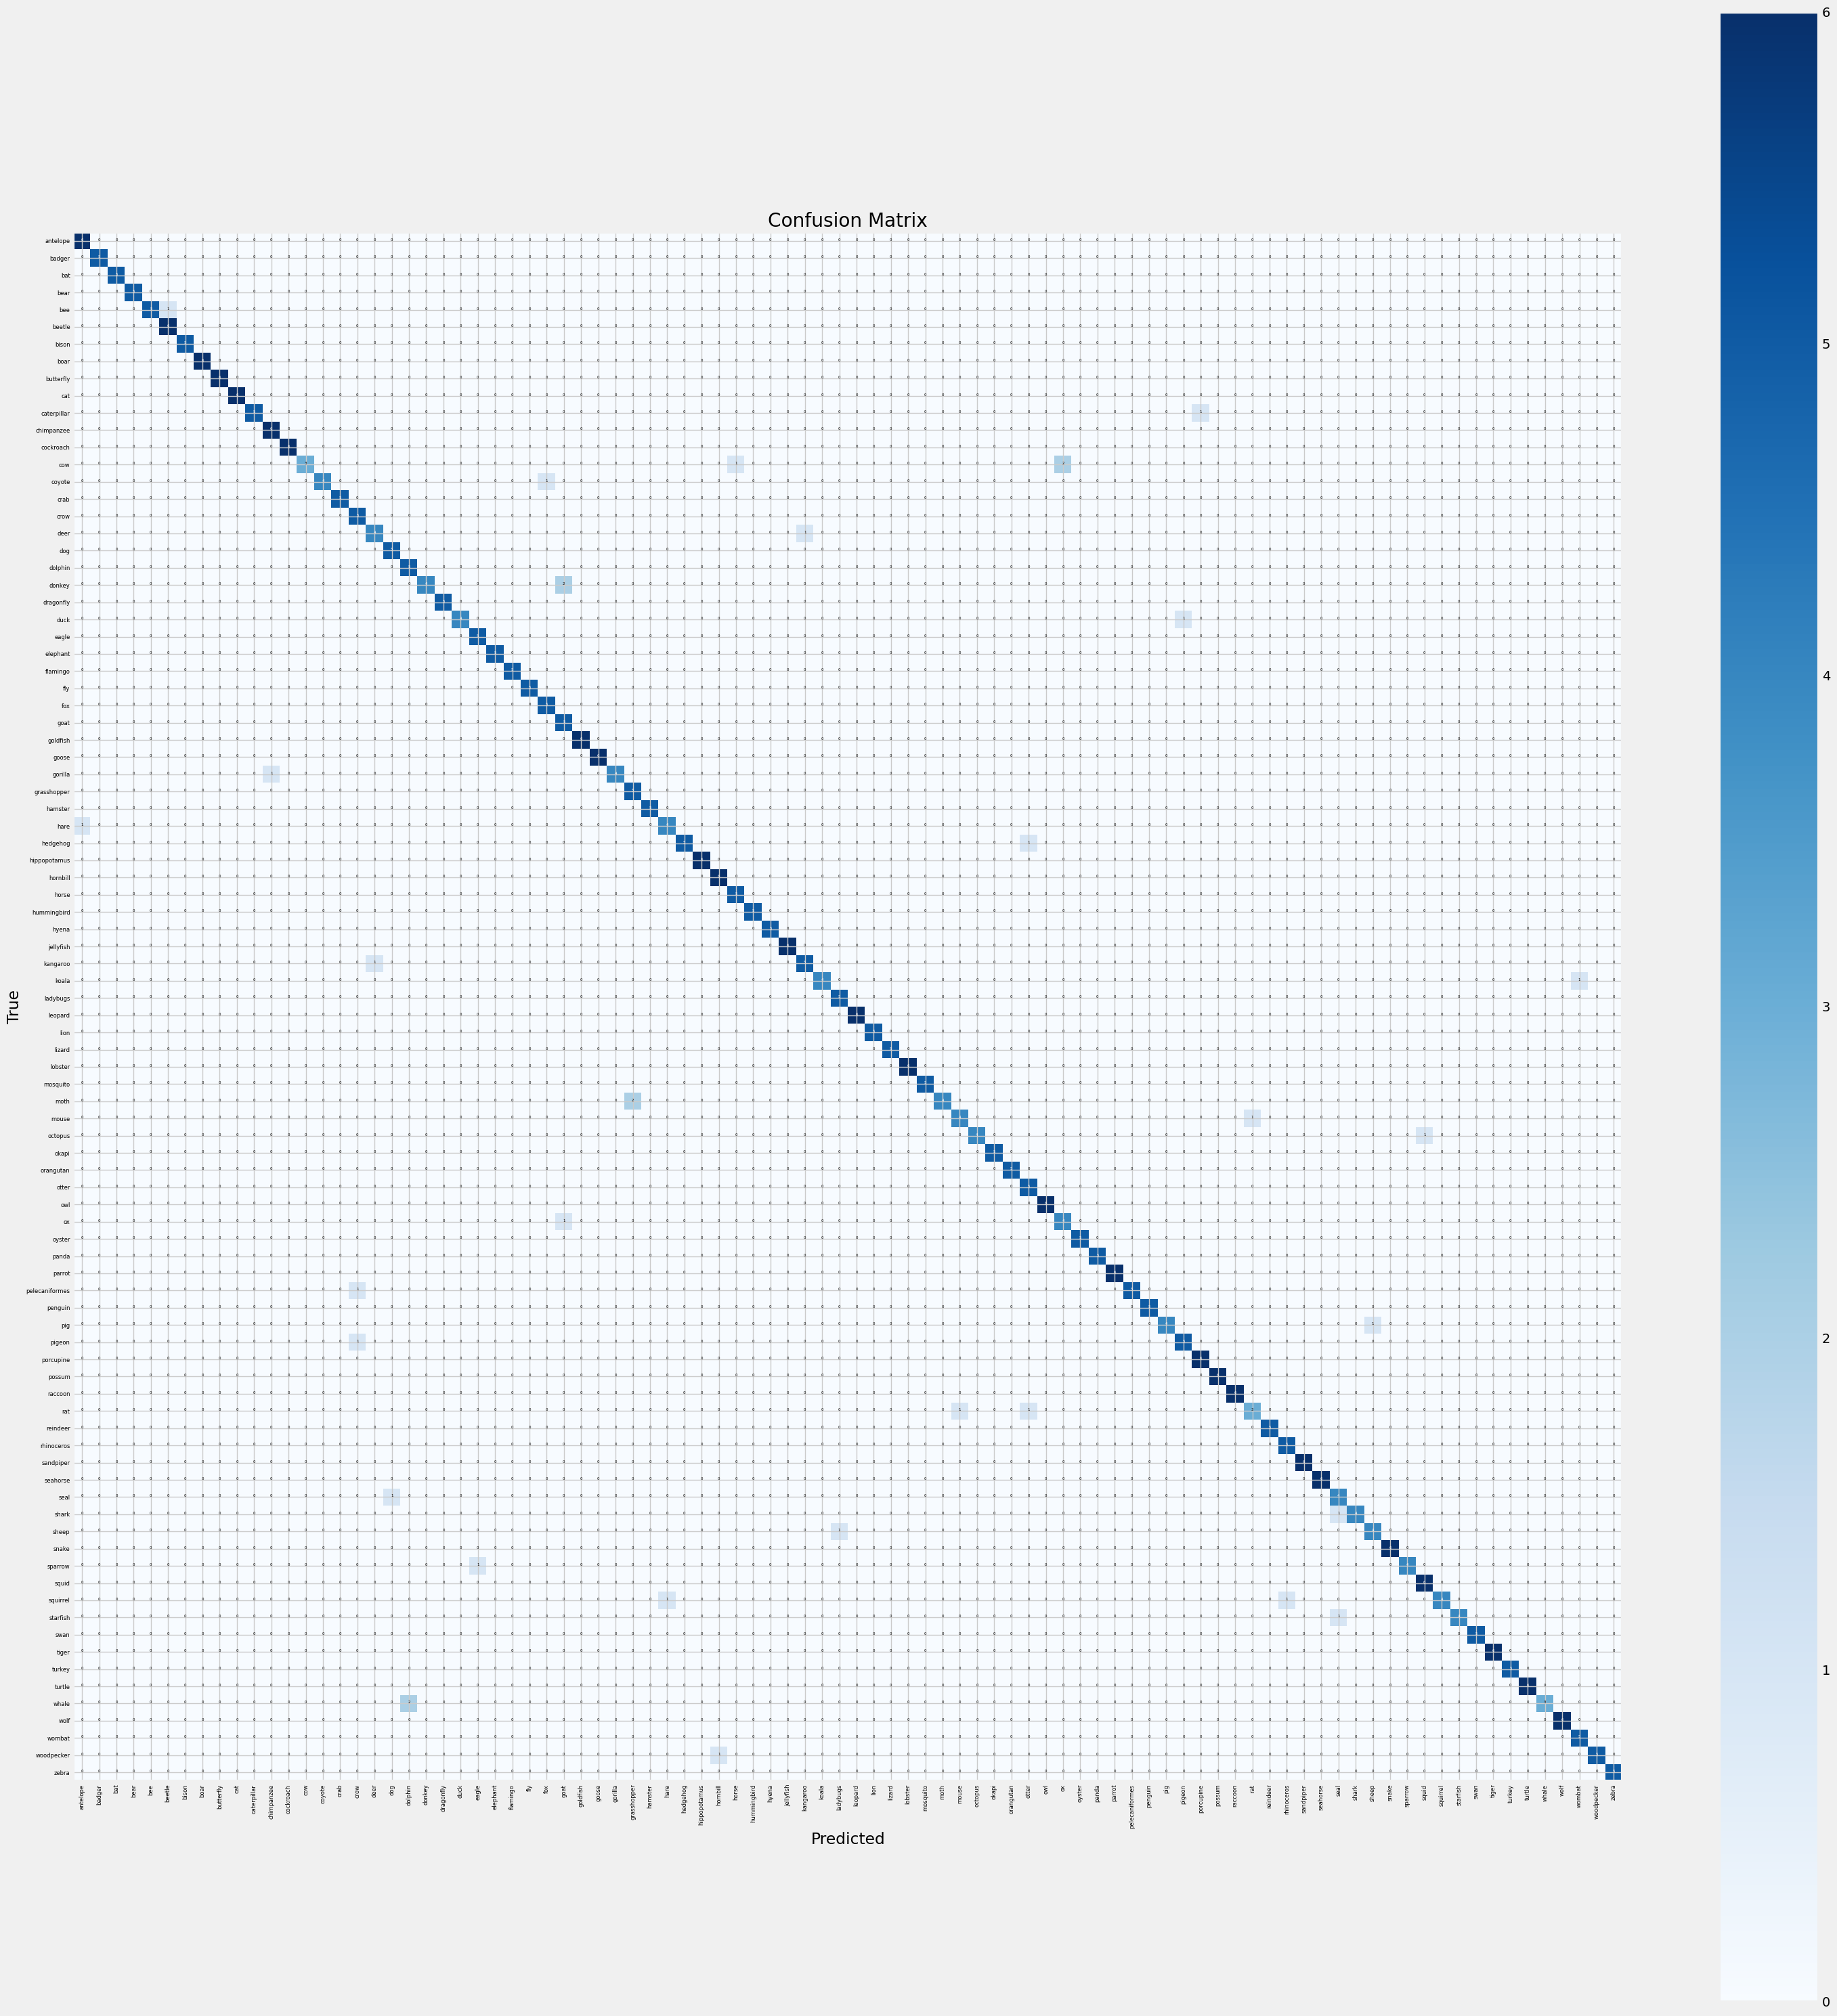

In [ ]:
y_test = list(test_data_generator.classes)
y_probs = best_model.predict(test_data_generator,verbose=0)
y_pred = np.argmax(y_probs,axis=1)
class_labels = list(test_data_generator.class_indices.keys())

print(f"F1 Score (Macro): {f1_score(y_test,y_pred,average='macro'):.3f}")

print("Confusion Matrix:")
cm = confusion_matrix(y_test,y_pred)
print(cm)

print("Classification Report:")
print(classification_report(y_test,y_pred,target_names=class_labels))

# Confusion Matrix Plot
plt.figure(figsize=(30, 30))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(class_labels))
plt.xticks(ticks, class_labels, rotation=90, fontsize=6)
plt.yticks(ticks, class_labels, fontsize=6) 

thresh = cm.max() / 2
for i, j in itertools.product(range(len(class_labels)), range(len(class_labels))):
    plt.text(j, i, f'{cm[i, j]}',
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black',
             fontsize=4)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show();

## Model Inference

In [ ]:
# Map class indices to labels
class_indices = train_data_generator.class_indices
idx_label_mapping = {v: k for k, v in class_indices.items()}

In [ ]:
def predict_animal(img_path):
    image = load_img(img_path, color_mode='rgb', target_size=IMG_SIZE)
    image_array = img_to_array(image)
    image_array = preprocess_input(image_array)
    image_batch = np.expand_dims(image_array, axis=0)  # Shape: (1, 224, 224, 3)

    prediction = best_model.predict(image_batch, verbose=0)
    predicted_idx = np.argmax(prediction, axis=1)[0]
    predicted_label = idx_label_mapping[predicted_idx]
    confidence = prediction[0][predicted_idx]

    # Display image with the predicted label
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence*100:.2f}%)", color='darkgreen')
    plt.show()

    return predicted_label, confidence

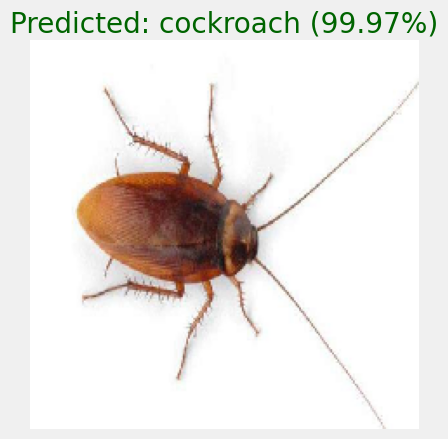

('cockroach', 0.99973994)

In [ ]:
sample_test_img_path = test_df.sample(random.randint(0,test_df.shape[0]))['image_filepath'].values[0]
predict_animal(sample_test_img_path)